# Simulating spectroscopy with <tt>synphot</tt>

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
<li>Query data directly from other websites using <code>astropy.coordinates.Skycoord</code>, <code>astroquery.Gaia</code>, <code>astropy.io</code>, and <code>astropy.utils</code></li>
<li>Construct a source spectrum using <code>synphot.SourceSpectrum</code></li>
<li>Model the effect of the quantum efficiency on the source spectrum with <code>synphot.SpectralElement</code></li>
<li>Combine all of these effects into a simulated spectroscopic observation with <code>synspec</code></li>
<li>Compute the expected count rate from this observation with <code>synphot</code>'s <code>countrate()</code> function
<li>Get the expected signal to noise ratios with <code>synphot.observation</code>'s <code>howell_snr()</code> and <code>exptime_from_howell_snr()</code>
</ul>

## Keywords
synphot, synthetic spectroscopy, astropy, astroquery, astronomy

## Summary
In this tutorial we will:
<ol>
<li><a href="#query_properties">Query the properties of our target star</a> (HAT-P-11 to start)</li>
<li><a href="#phoenix">Download model spectra from PHOENIX</a></li>
<li><a href="#source_spectrum">Construct a source spectrum</a></li>
<li><a href="#spectroscopy">Simulate an observation with a spectrometer</a></li>
<li><a href="#qe">Model the effect of the quantum efficiency</a></li>
<li><a href="#observation">Combine all of the effects and "observe"</a></li>
<li><a href="#counts">Compute the count rate and total counts</a></li>
<li><a href="#snr">Estimate the expected signal to noise ratio</a></li>
<li><a href="#trappist1">Look at another example, this time with TRAPPIST-1</a></li>
</ol>

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from synphot import units

The cell below will mute the warnings that astroquery raises, which will disappear anyway in the yet-to-be-released `astropy 4.0`

In [42]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

<a id='query_properties'></a>
## 1. Query the properties of HAT-P-11

First we get the star's parameters using astroquery's <a href="https://astroquery.readthedocs.io/en/latest/gaia/gaia.html">Gaia query</a> and astropy's <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">SkyCoord</a>: 

In [43]:
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

ID = 'HAT-P-11'

coord = SkyCoord.from_name(ID)
width = u.Quantity(1, u.arcmin)  # width / height of search
height = u.Quantity(1, u.arcmin)
search_results = Gaia.query_object_async(coordinate=coord, width=width, height=height)

# the queried star will be the one nearest to the given coordinates
search_results.add_index('dist', unique=True)
hatp11_info = search_results.loc['dist', min(search_results['dist'])]

# now get the parameters
stellar_radius = hatp11_info['radius_val'] * u.R_sun
# divide 1 AU by parallax (arcseconds) to get distance in parsecs.
# parallax is given in milliarcseconds, so multiply by 1000: 
distance = (1 / (hatp11_info['parallax']) * 1000) * u.pc
T_eff = hatp11_info['teff_val']

Query finished.


<a id="phoenix"></a>
## 2. Download a model spectrum for HAT-P-11 from <a href="http://phoenix.astro.physik.uni-goettingen.de/">PHOENIX</a>:

In [44]:
from astropy.io import fits

T_eff = round(T_eff, -2)  # round to nearest 100 K

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=int(T_eff), log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

<a id="source_spectrum"></a>
## 3. Construct a `synphot` <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">source spectrum object</a> from the above arrays:

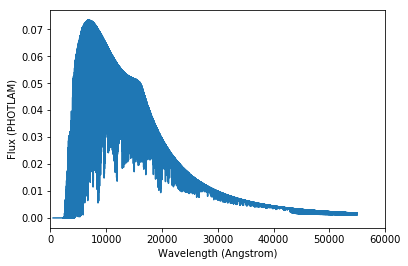

In [45]:
from synphot.spectrum import SourceSpectrum
from synphot.models import Empirical1D

photlam_hatp11 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
photlam_hatp11 = photlam_hatp11 * float(stellar_radius / distance) ** 2 / np.pi

photlam_hatp11.plot(flux_unit='PHOTLAM', left=0, right=60000)

(for other methods of constructing source spectra with `synphot`, see the first bulleted list <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">here</a>) 

<a id="spectroscopy"></a>
## 4. Simulate an observation with a spectrometer

We will model the spectrometer after the instrument on the planned <a href="https://en.wikipedia.org/wiki/CHEOPS">CHEOPS satellite</a>, setting a spectral resolution R = 1000.

In [57]:
aperture_radius = 32 / 2 * u.cm  # radius of 32 cm CHEOPS satellite
aperture_area = np.pi * aperture_radius ** 2
R = 1000  # spectral resolution lambda / delta_lambda

To see what the binned spectrum looks like before hitting the CCD, create a bandpass object from a box uniform bandpass of amplitude = 1, which is equivalent to observing through no filter:

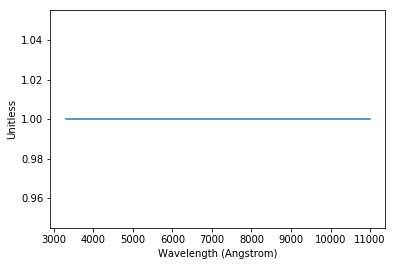

In [47]:
from synphot import SpectralElement
from astropy.modeling.models import Const1D

uniform_bp = SpectralElement(Const1D, amplitude=1)
uniform_bp.plot([3300, 11000])  # CHEOPS spectrometer will range from 3300 - 1100 angstroms

Now we simulate a spectroscopic observation of resolution R = &lambda;/&Delta;&lambda; (defined to be R = 1000 above) using `synspec` and its `from_R` function:

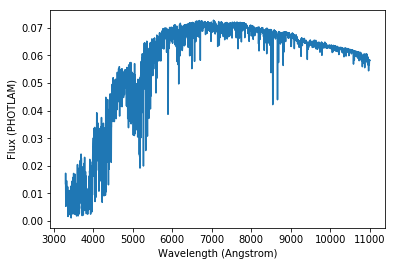

In [48]:
import synspec

waverange = np.array([0.33, 1.1]) * u.micron
observation_preccd = synspec.from_R(photlam_hatp11, uniform_bp, R, waverange, force='taper')
observation_preccd.plot()

### Plot the binned photometry (aka spectroscopy) on top of the source spectrum for comparison:

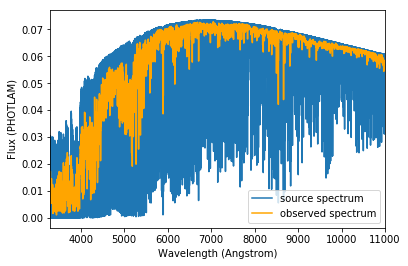

In [49]:
plt.plot(photlam_hatp11.waveset, photlam_hatp11(photlam_hatp11.waveset), label='source spectrum')
plt.step(observation_preccd.binset, observation_preccd.binflux, color='orange',
         label='observed spectrum', where='mid')
plt.xlim(3300, 11000)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

Zoom in on some spectral features to see the binning:

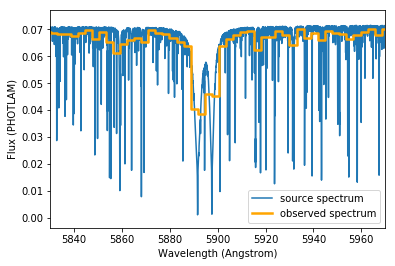

In [50]:
plt.plot(photlam_hatp11.waveset, photlam_hatp11(photlam_hatp11.waveset), label='source spectrum')
plt.step(observation_preccd.binset, observation_preccd.binflux, color='orange',
         label='observed spectrum', where='mid', lw=2.5)
plt.xlim(5830, 5970)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

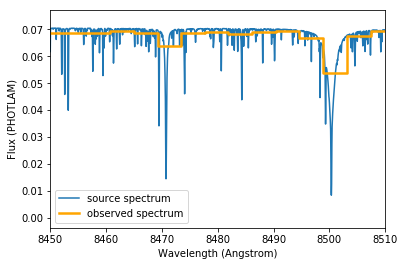

In [51]:
plt.plot(photlam_hatp11.waveset, photlam_hatp11(photlam_hatp11.waveset), label='source spectrum')
plt.step(observation_preccd.binset, observation_preccd.binflux, color='orange', label='observed spectrum',
         where='mid', lw=2.5)
plt.xlim(8450, 8510)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

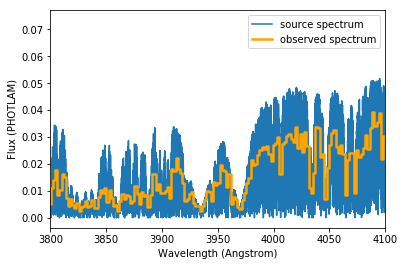

In [52]:
plt.plot(photlam_hatp11.waveset, photlam_hatp11(photlam_hatp11.waveset), label='source spectrum')
plt.step(observation_preccd.binset, observation_preccd.binflux, color='orange', label='observed spectrum',
         where='mid', lw=2.5)
plt.xlim(3800, 4100)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

<a id="qe"></a>
## 5. Model the effect of the CCD's quantum efficiency on the spectrum

For this we use the values in the table found in section 3.5 on <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/#3p5">this page</a>.

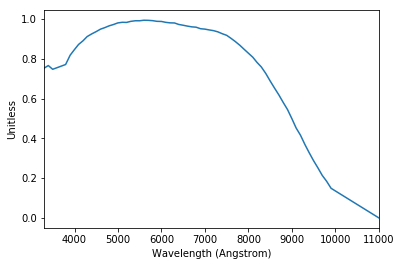

In [53]:
quantum_efficiency = SpectralElement.from_file('ccd_QE.csv', wave_unit="nm")
quantum_efficiency = quantum_efficiency / 100  # convert percentages to decimals

quantum_efficiency.plot(left=3300, right=11000)

<a id="observation"></a>
## 6. Combine the effects and "observe"

Finally, we convolve the source spectrum with the CCD efficiency and use `synspec.from_R` to simulate the spectroscopic observation:

(3300, 11000)

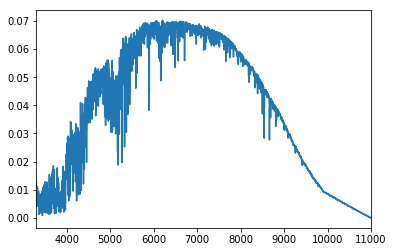

In [58]:
observation = synspec.from_R(photlam_hatp11, quantum_efficiency, R, waverange, force='taper')
plt.step(observation.binset, observation.binflux)
plt.xlim(3300, 11000)

(0.05, 0.075)

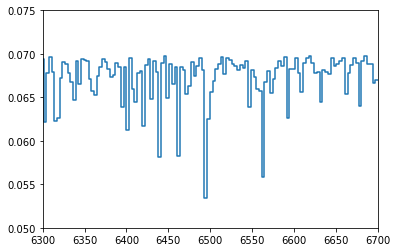

In [63]:
# zoom in to see binning
plt.step(observation.binset, observation.binflux)
plt.xlim(6300, 6700)
plt.ylim(0.05, 0.075)

<a id="counts"></a>
## 7. Compute the count rate and total counts

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method on the observation object: 

In [64]:
countrate = observation.countrate(area=aperture_area)

How many counts can we expect in a 10s exposure?

In [65]:
counts_hatp11 = countrate * 10 * u.s

print("HAT-P-11 counts in 10 s exposure:")
print(int(counts_hatp11.value), "cts")

HAT-P-11 counts in 10 s exposure:
2395321 cts


<a id="snr"></a>
## 8. Estimate the signal to noise ratio

To estimate the signal to noise ratio of this observation, input the total counts into `synphot`'s `howell_snr` function:

In [66]:
from synphot.observation import howell_snr

print("SNR of HAT-P-11 in 10 s exposure:")
howell_snr(counts_hatp11)

SNR of HAT-P-11 in 10 s exposure:


<Quantity 1547.68239568 ct(1/2)>

You can also use `synphot` to calculate the exposure time needed to obtain a certain SNR:

In [67]:
from synphot.observation import exptime_from_howell_snr

desired_snr = 100 * np.sqrt(1 * u.ct)

print("Exposure time needed to obtain SNR > 100:")
exptime_from_howell_snr(desired_snr, countrate)

Exposure time needed to obtain SNR > 100:


<Quantity 0.04174806 s>

<a id="trappist1"></a>
## 9. Another example, this time with <a href="https://en.wikipedia.org/wiki/TRAPPIST-1">TRAPPIST-1</a>

(using the same instrument and telescope)

In [68]:
T_eff = 2600  # approx temperature of trappist-1 [K], Gillon 2017

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

Unfortunately Gaia does not have all the parameters we need for TRAPPIST-1, so we use the values cited in <a href="https://arxiv.org/pdf/1703.01424.pdf">Gillon 2017</a>:

In [69]:
photlam_trappist1 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
stellar_radius = 0.117 * u.R_sun  # radius of trappist-1 in solar units
distance = 12.1 * u.pc  # distance to trappist-1 in parsecs
photlam_trappist1 = photlam_trappist1 * float(stellar_radius / distance) ** 2 / np.pi

"Observe": Bin the flux according to the spectral resolution, which this time we will define by a constant &Delta;&lambda; = 100 angstroms using `synspec`'s `from_wave_binwidth` function:

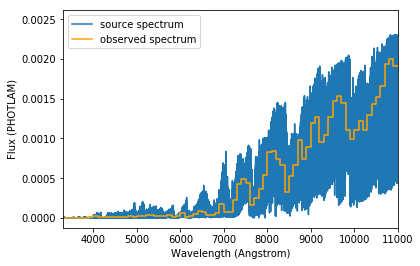

In [70]:
wavebin_width = 100 * u.angstrom
observation_preccd = synspec.from_wave_binwidth(photlam_trappist1, uniform_bp,
                                                wavebin_width, waverange=waverange,
                                                force='taper')

plt.plot(photlam_trappist1.waveset, photlam_trappist1(photlam_trappist1.waveset), label='source spectrum')
plt.step(observation_preccd.binset, observation_preccd.binflux, color='orange', label='observed spectrum')
plt.xlim(3300, 11000)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

Zoom in to see how spectral features translate:

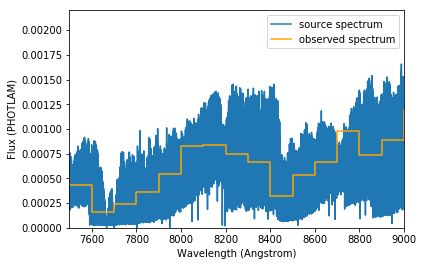

In [71]:
plt.plot(photlam_trappist1.waveset, photlam_trappist1(photlam_trappist1.waveset), label='source spectrum')
plt.step(observation_preccd.binset, observation_preccd.binflux, color='orange', label='observed spectrum')
plt.xlim(7500, 9000)
plt.ylim(0, 0.0022)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (PHOTLAM)')
plt.legend()

After hitting the CCD we get:

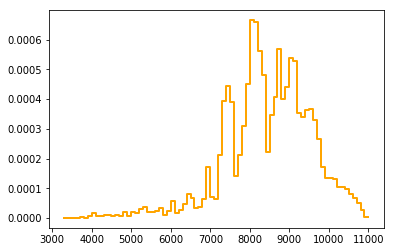

In [75]:
observation = synspec.from_wave_binwidth(photlam_trappist1, quantum_efficiency,
                                         wavebin_width, waverange=waverange,
                                         force='taper')
plt.step(observation.binset, observation.binflux, color='orange', lw=2)

In [76]:
countrate = observation.countrate(area=aperture_area)
counts_trappist1 = countrate * 10 * u.s

print("TRAPPIST-1 counts, 10 s exposure:")
print(int(counts_trappist1.value), "cts")

TRAPPIST-1 counts, 10 s exposure:
10142 cts


In [77]:
print("SNR of TRAPPIST-1 in 10 s exposure:")
howell_snr(counts_trappist1)

SNR of TRAPPIST-1 in 10 s exposure:


<Quantity 100.70989653 ct(1/2)>